# Using Convoluted Neural Networks to forecast Crop Yield from NDVI scaled Satellite Images

In [1]:
import os, sys
import pandas as pd
import numpy as np
import PIL.Image
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import (Input, Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D, Dropout,
                          Conv2DTranspose, concatenate)
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [167]:
IMG_PATH = 'C:\\Users\\anupriya\\Desktop\\ndvi_img\\'

In [168]:
img_name = []
for root, dirs, files in os.walk(IMG_PATH):
    for filename in files:
        img_name.append(filename)

In [169]:
len(img_name)

61

In [170]:
county = ['kings', 'fresno', 'sanjoaquin', 'solano', 'stanislaus', 'yolo']

In [171]:
img_load = []
for county in county:
    for root, dirs, files in os.walk(IMG_PATH+county+'/'):
        for filename in files:
            img_load.append(plt.imread(root+filename))

In [173]:
for arr in img_load:
    print(arr.shape)

In [174]:
len(img_load)

53

In [175]:
img_h = []
img_w = []

for arr in img_load:
    img_h.append(arr.shape[0])
    img_w.append(arr.shape[1])

In [176]:
print(min(img_h), max(img_h))
print(min(img_w), max(img_w))

150 316
102 357


In [203]:
# RESIZE IMAGES

#img = cv2.imread('YOUR_PATH_TO_IMG')
new_img = []

for img_arr in img_load:
    height, width = img_arr.shape[:2]
    max_height = 316
    max_width = 357

    if width < max_width or height < max_height:
        new_img.append(cv2.resize(img_arr, (357,316)))
    
    # only shrink if img is bigger than required
     if max_height < height or max_width < width:
        # get scaling factor
        scaling_factor = max_height / float(height)
        if max_width/float(width) < scaling_factor:
             scaling_factor = max_width / float(width)
         # resize image
         new_img.append(cv2.resize(img_arr, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA))

    cv2.imshow("Shrinked image", img)
    key = cv2.waitKey()

In [204]:
new_arr = []

for arr in img_load:
    
    target_h = int((arr.shape[0]-300)/2)
    target_w = int((arr.shape[1]-250)/2)
    new_arr.append(arr[target_h:300+target_h,target_w:250+target_w,:])

In [206]:
len(new_img)

53

In [207]:
new_img = np.array(new_img)

In [208]:
new_img.shape

(53, 316, 357, 4)

In [43]:
new_arr = np.array(new_arr)
new_arr.shape

In [182]:
# Load yield data
yield_df = pd.read_excel("USDA_yield_CAandOH.xlsx")
pd.set_option("display.max_columns", 100)

In [183]:
yield_df.head()

,,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,SURVEY,1973,YEAR,NaN,COUNTY,OHIO,39,NORTHWEST,10,OTHER (COMBINED) COUNTIES,NaN,NaN,NaN,0,NaN,TOMATOES,"TOMATOES, IN THE OPEN, PROCESSING - YIELD, MEA...",TOTAL,NOT SPECIFIED,1.60,NaN
1,SURVEY,1981,YEAR,NaN,COUNTY,OHIO,39,WEST CENTRAL,40,OTHER (COMBINED) COUNTIES,NaN,NaN,NaN,0,NaN,TOMATOES,"TOMATOES, IN THE OPEN, PROCESSING - YIELD, MEA...",TOTAL,NOT SPECIFIED,10.70,NaN
2,SURVEY,2002,YEAR,NaN,COUNTY,OHIO,39,WEST CENTRAL,40,OTHER (COMBINED) COUNTIES,NaN,NaN,NaN,0,NaN,TOMATOES,"TOMATOES, IN THE OPEN, PROCESSING - YIELD, MEA...",TOTAL,NOT SPECIFIED,12.14,NaN
3,SURVEY,1974,YEAR,NaN,COUNTY,OHIO,39,WEST CENTRAL,40,OTHER (COMBINED) COUNTIES,NaN,NaN,NaN,0,NaN,TOMATOES,"TOMATOES, IN THE OPEN, PROCESSING - YIELD, MEA...",TOTAL,NOT SPECIFIED,13.39,NaN
4,SURVEY,1975,YEAR,NaN,COUNTY,OHIO,39,WEST CENTRAL,40,OTHER (COMBINED) COUNTIES,NaN,NaN,NaN,0,NaN,TOMATOES,"TOMATOES, IN THE OPEN, PROCESSING - YIELD, MEA...",TOTAL,NOT SPECIFIED,13.41,NaN


In [184]:
yield_sub = yield_df[['Year', 'State', 'County', 'Value']]
yield_sub = yield_sub[yield_sub['Year'] >= 2000]

In [185]:
# Divide the df into CA and OHIO
ca_yield = yield_sub[yield_sub['State'] == 'CALIFORNIA']
oh_yield = yield_sub[yield_sub['State'] == 'OHIO']

In [186]:
ca = ca_yield.groupby(['County','Year'])[['Value']].sum()
ca.to_csv('ca.csv')

In [187]:
df = pd.read_csv('ca.csv')

In [188]:
len(df)

53

In [209]:
X = new_img
y = df.iloc[:,2]

In [49]:
# a = np.expand_dims(X_test, 0)
# a.shape

In [55]:
X_test = new_arr[-1]
y_test = yd.iloc[-1,1]
X_test = np.expand_dims(X_test, 0)

In [236]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [240]:
def cnn_model(n_channels=4, growth_factor=2, filter_size=(3,3)):
    # Creating network model using functional API:
    
    # first
    n_filters = n_channels*growth_factor
    
    inputs = Input((316, 357, n_channels))
    conv1 = Conv2D(n_filters, filter_size, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(n_filters, filter_size, activation='relu', padding='same')(conv1)
    pool1 = AveragePooling2D(pool_size=(2, 2))(conv1)
    
    # second
    n_filters *= growth_factor  # increase number of filters when going down the U-Net    
    conv2 = Conv2D(n_filters, filter_size, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(n_filters, filter_size, activation='relu', padding='same')(conv2)
    pool2 = AveragePooling2D(pool_size=(2, 2))(conv2)
 
    # third
    n_filters *= growth_factor  # increase number of filters when going down the U-Net    
    conv3 = Conv2D(n_filters, filter_size, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(n_filters, filter_size, activation='relu', padding='same')(conv3)
    pool3 = AveragePooling2D(pool_size=(2, 2))(conv3)

    # fourth
    n_filters *= growth_factor  # increase number of filters when going down the U-Net    
    conv4 = Conv2D(n_filters, filter_size, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(n_filters, filter_size, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    dropout = Dropout(0.3)

    # output
    fc1 = Flatten()(pool4)
    fc2 = Dense(4588, activation='linear')(fc1)
    output = Dense(1, kernel_initializer='normal',activation='linear')(fc1)
    model = Model(inputs=inputs, outputs=output)
    optimizer = Adam()
    # Compiling model with ADAM optimizer and logloss (aka binary crossentropy) as loss function
    model.compile(loss=root_mean_squared_error, optimizer='adam')
    return model

In [241]:
model = cnn_model(n_channels=4)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 316, 357, 4)       0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 316, 357, 8)       296       
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 316, 357, 8)       584       
_________________________________________________________________
average_pooling2d_10 (Averag (None, 158, 178, 8)       0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 158, 178, 16)      1168      
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 158, 178, 16)      2320      
_________________________________________________________________
average_pooling2d_11 (Averag (None, 79, 89, 16)        0         
__________

In [242]:
# Now training the model:
N_EPOCHS = 350
#BATCH_SIZE = 3000

# Fit:
history = model.fit(x=X, y=y, 
          epochs=N_EPOCHS, verbose=1, validation_split=0.1) 

Train on 47 samples, validate on 6 samples
Epoch 1/350
47/47 [==============================] - 6s 133ms/step - loss: 43.4737 - val_loss: 44.8890
Epoch 2/350
47/47 [==============================] - 6s 122ms/step - loss: 42.1869 - val_loss: 40.2367
Epoch 3/350
47/47 [==============================] - 6s 120ms/step - loss: 35.7834 - val_loss: 20.1272
Epoch 4/350
47/47 [==============================] - 6s 123ms/step - loss: 14.6553 - val_loss: 9.2753
Epoch 5/350
47/47 [==============================] - 6s 129ms/step - loss: 9.3142 - val_loss: 12.1292
Epoch 6/350
47/47 [==============================] - 6s 128ms/step - loss: 10.1029 - val_loss: 8.4422
Epoch 7/350
47/47 [==============================] - 6s 126ms/step - loss: 5.7238 - val_loss: 5.8574
Epoch 8/350
47/47 [==============================] - 6s 121ms/step - loss: 7.5976 - val_loss: 3.8408
Epoch 9/350
47/47 [==============================] - 6s 121ms/step - loss: 4.0774 - val_loss: 6.4160
Epoch 10/350
47/47 [===================

Epoch 81/350
47/47 [==============================] - 6s 120ms/step - loss: 3.1301 - val_loss: 3.5141
Epoch 82/350
47/47 [==============================] - 6s 121ms/step - loss: 3.2697 - val_loss: 6.1689
Epoch 83/350
47/47 [==============================] - 6s 119ms/step - loss: 3.7879 - val_loss: 2.7259
Epoch 84/350
47/47 [==============================] - 6s 119ms/step - loss: 4.1015 - val_loss: 5.7057
Epoch 85/350
47/47 [==============================] - 6s 119ms/step - loss: 3.8306 - val_loss: 7.2012
Epoch 86/350
47/47 [==============================] - 6s 118ms/step - loss: 4.0281 - val_loss: 3.2519
Epoch 87/350
47/47 [==============================] - 6s 119ms/step - loss: 3.0676 - val_loss: 4.7547
Epoch 88/350
47/47 [==============================] - 6s 118ms/step - loss: 3.1177 - val_loss: 3.0588
Epoch 89/350
47/47 [==============================] - 6s 119ms/step - loss: 3.1899 - val_loss: 5.3773
Epoch 90/350
47/47 [==============================] - 6s 119ms/step - loss: 3.3911

47/47 [==============================] - 6s 117ms/step - loss: 3.9464 - val_loss: 7.8395
Epoch 240/350
47/47 [==============================] - 6s 120ms/step - loss: 1.7747 - val_loss: 6.1745
Epoch 241/350
47/47 [==============================] - 6s 117ms/step - loss: 2.7155 - val_loss: 12.7627
Epoch 242/350
47/47 [==============================] - 6s 117ms/step - loss: 4.2509 - val_loss: 3.2197
Epoch 243/350
47/47 [==============================] - 6s 119ms/step - loss: 6.0871 - val_loss: 5.5752
Epoch 244/350
47/47 [==============================] - 5s 117ms/step - loss: 3.5256 - val_loss: 15.8145
Epoch 245/350
47/47 [==============================] - 5s 117ms/step - loss: 7.7937 - val_loss: 9.8484
Epoch 246/350
47/47 [==============================] - 6s 120ms/step - loss: 4.2969 - val_loss: 3.5027
Epoch 247/350
47/47 [==============================] - 6s 119ms/step - loss: 8.6152 - val_loss: 8.3472
Epoch 248/350
47/47 [==============================] - 6s 118ms/step - loss: 4.3370 -

In [226]:
model.save_weights('model_weights_v3.h5')

In [227]:
with open('model_architecture_v3.json', 'w') as f:
    f.write(model.to_json())

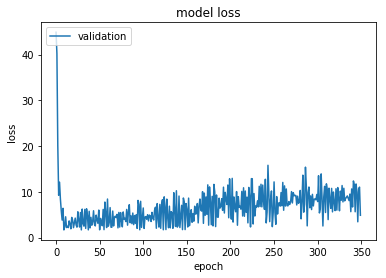

In [244]:
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation', 'test'], loc='upper left')
plt.show()

In [68]:
y_pred = model.predict(X_test)

In [69]:
y_pred

array([[53.27923]], dtype=float32)

In [70]:
y_test

51.88

In [71]:
np.mean(np.abs((y_test - y_pred) / y_test)) * 100

2.6970453560352325

% bias: 2.6970453560352325

In [74]:
100 * (sum(abs(y_test-y_pred)/(abs(y_test)+abs(y_pred))))/1

array([1.3305795], dtype=float32)

SMAPE: 1.3305795

In [84]:
from sklearn.metrics import mean_squared_error
from math import sqrt

sqrt(mean_squared_error(np.array([y_test]), y_pred))

1.3992282104492162

Error: 1.3992282104492162